# Local Sliding-Window Quantum Hypernetwork (SWQH)
**Objective:** Train a Hybrid Quantum-Classical Neural Network to predict the next token in a molecular sequence, conditioned on global molecular properties (logP, QED, MW).

**Architecture:**
* **Input:** 5-bit token encodings + 3 continuous property values.
* **Ansatz:** A variational quantum circuit using Strongly Entangling Layers and Diagonal Phase rotations ($e^{-i \phi Z \otimes Z}$).
* **Training:** JAX-based optimization using the Adam optimizer.

In [1]:
from typing import Tuple, List, Dict, Any

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem import Draw
import selfies as sf

import numpy as np
import math
from math import ceil, log2, comb
import re
import pandas as pd
import optax
import csv
import json
import itertools
from functools import partial
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import haiku as hk

import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers

import jax
import jax.random as random
from jax import random
import jax.numpy as jnp
import jax.nn as jnn
from jax.nn.initializers import normal
from IPython.display import SVG, display

# Data Preparation

In [2]:
# Load metadata from JSON
N_MOLECS = 10000
META_DATA_PATH = f"../data/metadata_selfies_{N_MOLECS}.json"
TIMESTAMP = time.strftime("%d%m%Y_%H")

with open(META_DATA_PATH, "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
BITS_PER_TOKEN = metadata['bits_per_token']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

print("Vocabulary Size:", VOCABULARY_SIZE)
print("Bits per Token:", BITS_PER_TOKEN)
print("Max Sequence Length:", MAX_LEN)
print("Alphabet:", ALPHABET)


Vocabulary Size: 32
Bits per Token: 5
Max Sequence Length: 34
Alphabet: ['<SOS>', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=PH1]', '[=P]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[H]', '[I]', '[NH1]', '[N]', '[O]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S]', '<EOS>', '<PAD>']


In [3]:
# --- Auxiliary functions ---
def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def denormalize(norm_value, min_val, max_val, target_max=np.pi):
    ''' Denormalize a value from [0, pi] back to its original range'''
    return (norm_value * (max_val - min_val) / target_max) + min_val

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [4]:
PAD_index = token_to_index("<PAD>")
SOS_index = token_to_index("<SOS>")
EOS_index = token_to_index("<EOS>")

In [5]:
def load_dataset_bits_batch(csv_path, n_bits=BITS_PER_TOKEN):
    """
    Read the dataset from a CSV file and convert it into bit representations for quantum processing.
    Args:
        csv_path (str): Path to the CSV file containing the dataset.
        n_bits (int): Number of bits used to represent each token.
    Returns:
        Tuple containing:
            - X_bits (jnp.ndarray): Input bit representations of shape (N_Molecules, MAX_LEN-1, n_bits).
            - Props (jnp.ndarray): Molecular properties of shape (N_Molecules, 3).
            - Y_indices (jnp.ndarray): Target token indices of shape (N_Molecules, MAX_LEN-1).
    """
    
    df = pd.read_csv(csv_path, dtype=str)
    print("Dataset loaded with shape:", df.shape)
    
    # Properties: logP, qed, mw
    # Shape: (N_Moleculas, 3)
    # Types: float
    props = df.iloc[:, :3].astype(float).values
    
    # Tokens
    # Shape: (N_Moleculas, MAX_LEN)
    # Types: string (e.g., "00101")
    token_cols = df.iloc[:, 3:].values
    
    # Auxiliary function to convert a string of '0's and '1's to a list
    def str_to_bit_list(s):
        return [int(c) for c in s]

    # 3D array to hold all bits
    all_bits = np.array([
        [str_to_bit_list(token) for token in row] 
        for row in token_cols
    ])
    
    # X_bits: Input for the model.
    # Take all tokens except the last one.
    X_bits = all_bits[:, :-1, :] 
    
    # Y_ind: Target indices for the model.
    # Take all tokens except the first one.
    # Convert from bit strings to integer indices (for loss calculation).
    Y_indices = np.array([[int(t, 2) for t in row[1:]] for row in token_cols])

    return jnp.array(X_bits), jnp.array(props), jnp.array(Y_indices)


In [6]:
data_path_train = f"../data/structured_data_selfies_{N_MOLECS}_train.csv"
print("Loaded training data:")
X_bits, Props, Y_ind = load_dataset_bits_batch(data_path_train)

print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)
print("------------------------------")


data_path_val = f"../data/structured_data_selfies_{N_MOLECS}_val.csv"
print("Loaded validation data:")
X_bits_val, Props_val, Y_ind_val = load_dataset_bits_batch(data_path_val)

print("X_bits shape:", X_bits_val.shape) # (N, L, 5)
print("Props shape:", Props_val.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_val.shape)   # (N, L)
print("------------------------------")


data_path_test = f"../data/structured_data_selfies_{N_MOLECS}_test.csv"
print("Loaded validation data:")
X_bits_test, Props_test, Y_ind_test = load_dataset_bits_batch(data_path_test)

print("X_bits shape:", X_bits_test.shape) # (N, L, 5)
print("Props shape:", Props_test.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_test.shape)   # (N, L)

Loaded training data:
Dataset loaded with shape: (6623, 37)
X_bits shape: (6623, 33, 5)
Props shape: (6623, 3)
Y_ind shape: (6623, 33)
------------------------------
Loaded validation data:
Dataset loaded with shape: (1419, 37)
X_bits shape: (1419, 33, 5)
Props shape: (1419, 3)
Y_ind shape: (1419, 33)
------------------------------
Loaded validation data:
Dataset loaded with shape: (1420, 37)
X_bits shape: (1420, 33, 5)
Props shape: (1420, 3)
Y_ind shape: (1420, 33)


## Quantum Circuit

### The Quantum Circuit (Variational Ansatz)

This is the core of the implementation. The circuit accepts:
1.  **Molecular Properties:** Encoded via $R_y(\theta)$ rotations.
2.  **Current Token:** Encoded via Basis Encoding.
3.  **Context Vector:** Encoded via rotations.

The ansatz consists of $L$ layers of:
1.  **Unitary $V(\theta)$:** Strongly Entangling layers to mix information.
2.  **Diagonal $\Sigma(\gamma)$:** Multi-Z rotations to introduce non-linearity and entanglement specific to the Ising Hamiltonian structure often found in quantum dynamics.


In [7]:
def zstring_combos(wires):
    """
    Return an ordered list of wire-tuples for all Z-strings up to order H_LOCAL.
    Order: all 1-local, then all 2-local, ..., up to H_LOCAL.
    """
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def num_zstrings(n_wires):
    """
    Count how many Z-strings up to order H_LOCAL.
    """
    return sum(comb(n_wires, k) for k in range(1, H_LOCAL + 1))

In [8]:
# Circuit parameters -------------------------------------------------------------------
N_LAYERS = 8  # number of variational layers
H_LOCAL = 3 # h_local sets the maximum number of qubits that interact in the Z terms
# --------------------------------------------------------------------------------------


# Name the qubit wires explicitly
n_prop_qubits = 3  # number of qubits needed to encode properties (logP, QED, MW)
n_ancillas = 3  # number of ancilla qubits that represent the environment
n_total_qubits = n_prop_qubits + BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires
tw_aw = token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)
#dev = qml.device("lightning.qubit", wires=all_wires)


def molecular_property_encoder(props):
    """Encode continuous props on property qubits via RY rotations"""
    for wire, val in zip(prop_wires, props):
        qml.RY(val, wires=wire)


def token_encoder(token_bits):
    """Soft basis encoding using RX rotation"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * jnp.pi 
        qml.RX(angle, wires=token_wires[i])


def conditional_injection(gamma):
    """Property injection via controlled RX gates"""
    param_idx = 0
    for prop_w in prop_wires:
        for token_w in token_wires:
            qml.CRX(gamma[param_idx], wires=[prop_w, token_w])
            param_idx += 1


def entangling_layer(theta):    
    # Rotations RX, RY, RZ
    target_wires = token_wires + ancilla_wires
    
    for i, wire in enumerate(target_wires):
        qml.RX(theta[i, 0], wires=wire)
        qml.RY(theta[i, 1], wires=wire)
        qml.RZ(theta[i, 2], wires=wire)
    
    # CNOT Ring
    for i in range(len(tw_aw)):
        qml.CNOT(wires=[tw_aw[i], tw_aw[(i+1) % len(tw_aw)]])


def hamiltonian_layer(sigma, time=1.0, combos=None):
    """
    Diagonal multi-Z unitary Σ = exp(i * sum_s gamma_s * Z^{⊗|s|} * t)
    using a flat parameter vector 'gamma_vec' aligned with 'combos'.
    """
    if combos is None:
        combos = zstring_combos(tw_aw)

    # Safety: ensure the vector length matches the number of combos
    assert sigma.shape[0] == len(combos), \
        f"sigma has length {sigma.shape[0]} but expected {len(combos)}"

    # MultiRZ(phi) = exp(-i * phi/2 * Z^{⊗k}); choose phi = -2 * sigma * time
    for sigma, combo in zip(sigma, combos):
        qml.MultiRZ(-2.0 * sigma * time, wires=list(combo))


@qml.qnode(dev, interface="jax", diff_method="backprop")
def autoregressive_model(token_bits, props, theta, gamma, sigma):
    """
    QNode for the autoregressive model.
    Args:
        token_bits: Bit representation of input tokens (shape: BITS_PER_TOKEN,)
        props: Molecular properties (shape: 3,)
        theta: Variational parameters for operator layers (shape: N_LAYERS, n_token_ancilla, 3)
        gamma: Property entanglement parameters (shape: N_LAYERS, n_prop_qubits, n_token_ancilla, 2)
        sigma: Parameters for Sigma layers (shape: N_LAYERS, num_zstrings)
    Returns:
        Probabilities over token qubits.
    """
    token_encoder(token_bits)               # Basis-encode token bits
    combos = zstring_combos(tw_aw)      # Precompute Z-string combos

    for l in range(N_LAYERS):
        # Re-encode molecular properties at each layer
        molecular_property_encoder(props)

        # Property Injection (CRX)
        conditional_injection(gamma[l])
        
        # Entangling Layer U_mix(θ)
        entangling_layer(theta[l])

        # Diagonal Hamiltonian U(σ)
        hamiltonian_layer(sigma[l], time=1.0, combos=combos)

    return qml.probs(wires=token_wires)


### Classical Embedding

In [9]:
def prepare_sliding_window_context(x_batch, window_size=3):
    """
    Creates the context input for the Embedding Network for the entire batch/sequence.
    Args:
        x_batch: (Batch, Length, Bits)
        window_size: Number of previous tokens to include in the context
    Returns:
        context_matrix: (Batch, Length, window_size * Bits)
    """
    B, L, Bits = x_batch.shape
    
    # 1. Pad the beginning with SOS tokens (zeros) so t=0 has a valid context
    # We need 'window_size' padding steps
    padding = jnp.zeros((B, window_size, Bits), dtype=x_batch.dtype)
    padded_x = jnp.concatenate([padding, x_batch], axis=1) # (B, L + window, Bits)
    
    # 2. Create the sliding windows
    # We want context at t to contain: t-3, t-2, t-1
    windows = []
    for i in range(L):
        # Slice a window of 3 tokens, flatten them to a single vector
        # Slice from i to i+window_size
        window = padded_x[:, i : i + window_size, :] # (B, 3, 5)
        flat_window = window.reshape(B, -1)          # (B, 15)
        windows.append(flat_window)
        
    return jnp.stack(windows, axis=1) # (B, L, 15)

# Update Embedding Network to handle generic shapes (Haiku is flexible by default)
def embedding_network_fn(x):
    # We expect input x to be (..., window_size * bits)
    # Output must match theta shape: (N_LAYERS * n_token_ancilla * 3)
    output_dim = N_LAYERS * (BITS_PER_TOKEN + n_ancillas) * 3
    
    mlp = hk.Sequential([
        hk.Linear(64), jax.nn.relu,
        hk.Linear(64), jax.nn.relu,
        hk.Linear(output_dim) 
    ])
    return mlp(x)

embedding_network = hk.transform(embedding_network_fn)

### Loss Function

**Cross Entropy ($\mathcal{L}_{CE}$):** Ensures the model predicts the correct next token (with Label Smoothing to prevent overfitting).

In [10]:
def total_loss_fn(pred_probs, target_indices, epsilon=0.1):
    """
    Computes normalized loss for a Batch of sequences.
    Handles prop_expvals whether it comes as a list or an array.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
        epsilon: Label smoothing factor for cross-entropy loss
    Returns:
        Normalized combined loss (scalar)
    """
        
    # 1. Get dimensions
    vocab_size = pred_probs.shape[-1] 
    
    # 2. Flatten dimensions for easier processing (B*L, Vocab)
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = target_indices.reshape(-1)
    
    # 3. Cross-Entropy with Label Smoothing
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    smooth_target = jnp.full_like(flat_probs, epsilon / (vocab_size - 1))
    smooth_target = jnp.where(target_one_hot == 1, 1.0 - epsilon, smooth_target)
    
    loss_per_token = -jnp.sum(smooth_target * jnp.log(flat_probs + 1e-10), axis=-1)

    # 5. Masking (Ignore PAD tokens)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # 6. Normalize
    num_real_tokens = jnp.sum(mask) + 1e-9
    mean_ce = jnp.sum(loss_per_token * mask) / num_real_tokens
    max_loss_scale = jnp.log(vocab_size)
    normalized_loss = mean_ce / max_loss_scale
    
    return normalized_loss, mean_ce

    
def compute_accuracy_masked(pred_probs, target_indices):
    """
    Calculates accuracy over non-PAD tokens.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
    Returns:
        Normalized accuracy (scalar)
    """
    # Get the predicted token indices (highest probability)
    predicted_indices = jnp.argmax(pred_probs, axis=-1)
    
    # Compare predictions to targets
    correct_predictions = (predicted_indices == target_indices)
    
    # Make to ignore PAD tokens
    mask = (target_indices != PAD_index)
    
    # Sum correct predictions over non-PAD tokens
    numerator = jnp.sum(correct_predictions * mask)
    
    # Divide by number of non-PAD tokens (epsilon to avoid div by zero)
    denominator = jnp.sum(mask) + 1e-9
    
    return numerator / denominator


## Model Training and Validation

This section implements the core optimization process. For each epoch, the execution follows two distinct phases:

1.  **Training Phase:** The model iterates over the **Training Set**, calculating gradients and updating the variational parameters ($\theta$) to minimize the combined loss function.
2.  **Validation Phase:** The model evaluates its current state on the held-out **Validation Set**. This is a **pure inference** step (no backpropagation) that strictly measures performance without updating weights.

**Objective:** By monitoring Validation Loss alongside Training Loss, we assess the model's ability to **generalize** to unseen chemical structures. This allows us to implement **Checkpointing**: we save the model parameters *only* when the Validation Loss reaches a new minimum, effectively preventing overfitting by discarding epochs where the model begins to memorize the training data.

In [11]:
# Token embedding parameters
rng = jax.random.PRNGKey(0)
dummy_context = jnp.zeros((3 * BITS_PER_TOKEN,), dtype=jnp.float32)  # 3 prev. tokens
embedding_params = embedding_network.init(rng, dummy_context)

# Effective qubit counts in variational layers
n_token_ancilla = BITS_PER_TOKEN + n_ancillas
n_dense_connections = n_prop_qubits * BITS_PER_TOKEN

# Initialize theta and sigma params
key = jax.random.PRNGKey(42)
key, k_theta, k_gamma, k_sigma, k_scale = jax.random.split(key, 5)

# Precompute Z-string combos once
token_ancilla_ws = token_wires + ancilla_wires
combos = zstring_combos(token_ancilla_ws)
n_combos = len(combos)

# Combine all trainable parameters into a single dictionary
combined_params = {
    # Quantum
    'theta': jax.random.normal(k_theta, (N_LAYERS, n_token_ancilla, 3)) * 0.1,
    'gamma': jax.random.normal(k_gamma, (N_LAYERS, n_dense_connections)) * 0.1,
    'sigma': jax.random.normal(k_sigma, (N_LAYERS, n_combos)) * 0.1,
    # Classical
    'embedding': embedding_params
}

# Training hyperparams
N_EPOCHS = 100
BATCH_SIZE = 16
N_SAMPLES = len(X_bits)
STEPS_PER_EPOCH = N_MOLECS // BATCH_SIZE

# Optimizer with Scheduler: warm up for 10 epochs, then decay
total_steps = N_EPOCHS * STEPS_PER_EPOCH

# Warmup + Cosine Decay Schedule
# Start at 0.0, go up to 0.001 in 10 epochs, then decay
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,              # Start from zero to stabilize gradients
    peak_value=0.001,            # Reduced from 0.005 to 0.001
    warmup_steps=10 * STEPS_PER_EPOCH,  # Warmup for first 10 epochs
    decay_steps=N_EPOCHS * STEPS_PER_EPOCH,
    end_value=0.0001             # Decay to a small non-zero value
)

optimizer = optax.adamw(learning_rate=schedule, weight_decay=1e-2)

opt_state = optimizer.init(combined_params)

In [12]:
def single_token_step(params, x_token, x_props, context_vec):
    """
    Predicts for a single token in a sequence using the params dictionary.
    """
    # Unpack parameters from the dictionary
    theta_base = params['theta']
    gamma = params['gamma']
    sigma = params['sigma']
    emb_params = params['embedding']

    # A. Run Embedding Network to get Theta Shift
    delta_theta_flat = embedding_network.apply(emb_params, None, context_vec)
    
    # Reshape to match Quantum Circuit Parameters (N_LAYERS, n_wires, 3)
    n_layers, n_wires, n_dims = theta_base.shape
    delta_theta = delta_theta_flat.reshape((n_layers, n_wires, n_dims))
    
    # B. Apply Shift
    theta_effective = theta_base + delta_theta
    
    # C. Run Quantum Circuit
    return autoregressive_model(x_token, x_props, theta_effective, gamma, sigma)

# 2. Vectorize over Sequence Length (L)
sequence_predict = jax.vmap(
    single_token_step, 
    in_axes=(None, 0, None, 0) 
    # params: None      (Shared)
    # x_token: 0        (Iterate over L)
    # x_props: None     (Shared for all tokens in molecule)
    # context_vec: 0    (Iterate over L)
)

# 3. Vectorize over Batch (B)
batch_predict = jax.vmap(
    sequence_predict,
    in_axes=(None, 0, 0, 0)
    # params: None      (Shared)
    # x_batch: 0        (Iterate over Batch)
    # props_batch: 0    (Iterate over Batch)
    # context_batch: 0  (Iterate over Batch)
)

In [13]:
@jax.jit
def training_step_batched(params, opt_state, x_batch, props_batch, y_indices_batch):
    
    def loss_fn(params):
        # 1. Prepare Context
        context_batch = prepare_sliding_window_context(x_batch, window_size=3)
        
        # 2. Run Batch Prediction
        pred_probs = batch_predict(
            params, 
            x_batch, 
            props_batch, 
            context_batch
        )
        
        # 3. Calculate Loss
        final_loss, token_loss = total_loss_fn(
            pred_probs,
            y_indices_batch, 
        )
        
        return final_loss, (token_loss, pred_probs)

    # Compute Gradients
    (loss, (token_loss, pred_probs)), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    
    # Update Weights
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    # Calculate Accuracy
    acc = compute_accuracy_masked(pred_probs, y_indices_batch)
    
    # Return 5 values: params, loss, state, grads, accuracy
    return new_params, loss, opt_state, grads, acc, token_loss

In [14]:
@jax.jit
def validation_step_batched(params, x_bits_batch, prop_batch, y_target_indices):
    
    # 1. Context
    context_batch = prepare_sliding_window_context(x_bits_batch, window_size=3)
    
    # 2. Prediction (Clean signature)
    pred_probs = batch_predict(
        params, 
        x_bits_batch, 
        prop_batch, 
        context_batch
    )
    
    # 3. Metrics
    loss,_ = total_loss_fn(pred_probs, y_target_indices)
    acc = compute_accuracy_masked(pred_probs, y_target_indices)
    
    return loss, acc

In [15]:
print(f"Starting training with {N_SAMPLES} molecules.")
print(f"Batch Size: {BATCH_SIZE} | Steps per epoch: {STEPS_PER_EPOCH}")

# Create directory for checkpoints if it doesn't exist
ckpt_dir = '../data/params/'
os.makedirs(ckpt_dir, exist_ok=True)

key = random.PRNGKey(42)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
best_val_loss = float('inf')
token_loss_history = []

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time() # Track time per epoch

    # --- Training Phase ---
    total_loss = 0.0
    total_acc = 0.0

    total_token_loss = 0.0

    # Shuffle data at the start of each epoch to improve generalization
    key, subkey = random.split(key)
    perm = random.permutation(subkey, N_SAMPLES)
    X_shuffled = X_bits[perm]
    P_shuffled = Props[perm]
    Y_shuffled = Y_ind[perm]

    for step in range(0, N_SAMPLES, BATCH_SIZE):
        # 1. Create the Batch (Slicing)
        idx_end = min(step + BATCH_SIZE, N_SAMPLES)
        
        x_batch = X_shuffled[step:idx_end]      # (BATCH_SIZE, 30, 5)
        prop_batch = P_shuffled[step:idx_end]   # (BATCH_SIZE, 3)
        y_batch = Y_shuffled[step:idx_end]      # (BATCH_SIZE, 30)
        
        if len(x_batch) == 0: continue

        # 2. Train all the batch at once
        combined_params, loss, opt_state, grads, acc, token_loss = training_step_batched(
            combined_params, 
            opt_state, 
            x_batch, 
            prop_batch, 
            y_batch
        )
        
        # 3. Accumulate metrics
        batch_n = len(x_batch)
        total_loss += loss * batch_n
        total_acc += acc * batch_n
        grad_norm = optax.global_norm(grads)

        total_token_loss += token_loss * batch_n
 
    # Average metrics over epoch
    avg_loss = total_loss / N_SAMPLES
    avg_acc = total_acc / N_SAMPLES

    loss_history.append(float(avg_loss))
    acc_history.append(float(avg_acc))

    token_loss_history.append(float(total_token_loss / N_MOLECS))

    # ------ Validation Phase ------
    val_total_loss = 0.0
    val_total_acc = 0.0
    N_VAL = len(X_bits_val)
    
    # Iterate through Validation Data
    for v_step in range(0, N_VAL, BATCH_SIZE):
        v_idx_end = min(v_step + BATCH_SIZE, N_VAL)
        
        vx_batch = X_bits_val[v_step:v_idx_end]
        vp_batch = Props_val[v_step:v_idx_end]
        vy_batch = Y_ind_val[v_step:v_idx_end]
        
        if len(vx_batch) == 0: continue

        # Pure Inference (No optimizer update, no gradients)
        v_loss, v_acc = validation_step_batched(
            combined_params, 
            vx_batch, 
            vp_batch, 
            vy_batch
        )
        
        v_batch_n = len(vx_batch)
        val_total_loss += v_loss * v_batch_n
        val_total_acc += v_acc * v_batch_n

    val_avg_loss = val_total_loss / N_VAL
    val_avg_acc = val_total_acc / N_VAL
    val_loss_history.append(float(val_avg_loss))
    val_acc_history.append(float(val_avg_acc))

    epoch_time = time.time() - epoch_start_time

    # Print both Train and Val metrics
    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f} | Val Loss: {val_avg_loss:.4f} | Val Acc: {val_avg_acc:.4f} | Time: {epoch_time:.2f}s")
    print(f"           | Token Loss: {token_loss_history[-1]:.4f}")


    # Checkpointing (Save Best Model)
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        
        # Save with a specific name indicating it is the "best"
        save_path = os.path.join(ckpt_dir, f"embedding_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl")
        
        with open(save_path, "wb") as f:
            pickle.dump(combined_params, f)

Starting training with 6623 molecules.
Batch Size: 16 | Steps per epoch: 625
Epoch 001 | Train Loss: 1.0164 | Train Acc: 0.0681 | Val Loss: 0.9175 | Val Acc: 0.2316 | Time: 1270.99s
           | Token Loss: 2.3330
Epoch 002 | Train Loss: 0.8463 | Train Acc: 0.3075 | Val Loss: 0.7891 | Val Acc: 0.3484 | Time: 1242.27s
           | Token Loss: 1.9427
Epoch 003 | Train Loss: 0.7501 | Train Acc: 0.4201 | Val Loss: 0.7212 | Val Acc: 0.4458 | Time: 2219.82s
           | Token Loss: 1.7218
Epoch 004 | Train Loss: 0.6991 | Train Acc: 0.4573 | Val Loss: 0.6839 | Val Acc: 0.4666 | Time: 1199.18s
           | Token Loss: 1.6047
Epoch 005 | Train Loss: 0.6701 | Train Acc: 0.4796 | Val Loss: 0.6622 | Val Acc: 0.4874 | Time: 1227.70s
           | Token Loss: 1.5381
Epoch 006 | Train Loss: 0.6531 | Train Acc: 0.4952 | Val Loss: 0.6492 | Val Acc: 0.4990 | Time: 1272.77s
           | Token Loss: 1.4990
Epoch 007 | Train Loss: 0.6418 | Train Acc: 0.5076 | Val Loss: 0.6399 | Val Acc: 0.5128 | Time: 1273.

### Training and Validation Visualization
To verify convergence and check for overfitting, we visualize the loss landscape and prediction accuracy over time for both the training and validation sets.

* **Loss (Blue/Navy):** Represents the combined objective (Cross-Entropy + Property MSE).
    * **Solid Line:** Training Loss. A steady decrease indicates the circuit is successfully learning.
    * **Dashed Line:** Validation Loss. If this starts increasing while Training Loss decreases, the model is overfitting.
* **Accuracy (Orange/Red):** Measures the percentage of correctly predicted next-tokens (masked for padding).
    * **Solid Line:** Training Accuracy.
    * **Dashed Line:** Validation Accuracy. This is the true measure of generalization.

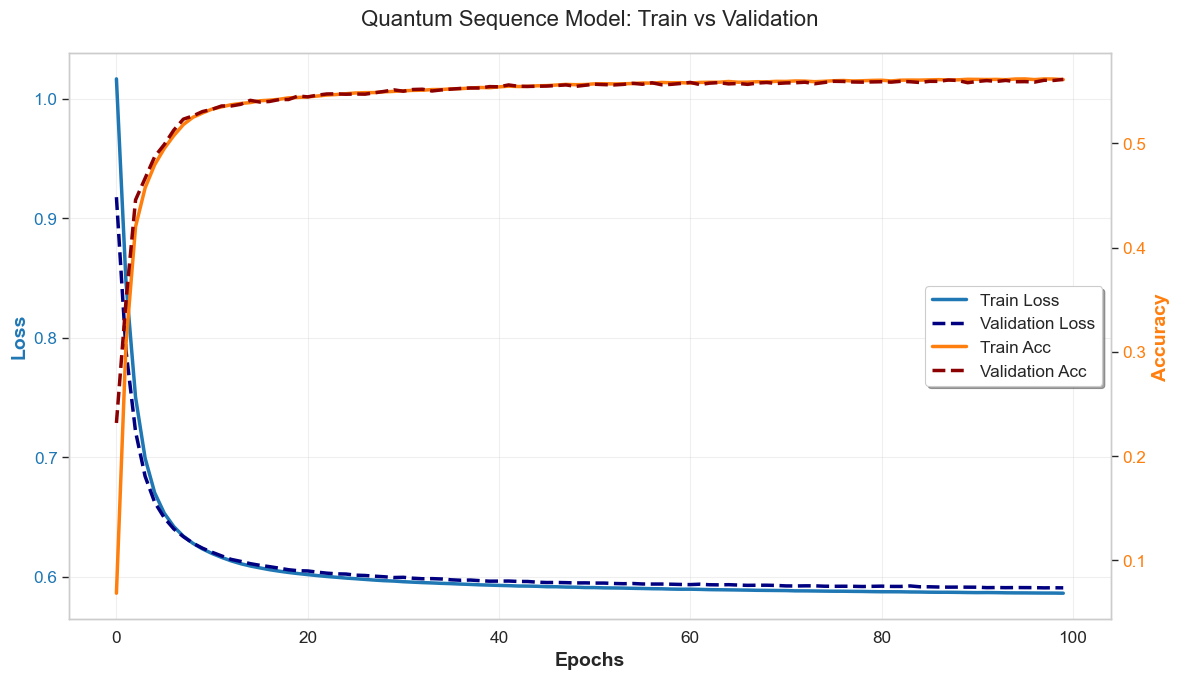

In [16]:
# Set the aesthetic style
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# Create figure and primary axis (Loss)
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Plot Loss (Left Axis) ---
color_train_loss = 'tab:blue'
color_val_loss = 'navy'

ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color=color_train_loss, fontsize=14, fontweight='bold')

# Train Loss (Solid)
line1 = ax1.plot(loss_history, color=color_train_loss, linewidth=2.5, label='Train Loss')
# Val Loss (Dashed)
line2 = ax1.plot(val_loss_history, color=color_val_loss, linewidth=2.5, linestyle='--', label='Validation Loss')

ax1.tick_params(axis='y', labelcolor=color_train_loss)
ax1.grid(True, alpha=0.3)

# --- Plot Accuracy (Right Axis) ---
ax2 = ax1.twinx()
color_train_acc = 'tab:orange'
color_val_acc = 'darkred'

ax2.set_ylabel('Accuracy', color=color_train_acc, fontsize=14, fontweight='bold')

# Train Accuracy (Solid)
line3 = ax2.plot(acc_history, color=color_train_acc, linewidth=2.5, label='Train Acc')
# Val Accuracy (Dashed)
line4 = ax2.plot(val_acc_history, color=color_val_acc, linewidth=2.5, linestyle='--', label='Validation Acc')

ax2.tick_params(axis='y', labelcolor=color_train_acc)
ax2.grid(False)

# --- Combined Legend ---
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=True, fancybox=True, shadow=True)

# Title and Layout
plt.title('Quantum Sequence Model: Train vs Validation', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Final Test Phase: Unbiased Evaluation

This section performs the final evaluation of the optimized model on the **Test Set**, which has been completely withheld during the training and hyperparameter tuning phases.

**Objective:** To report the true generalization performance of the model on unseen data.

**Process:**
1.  **Load Best Model:** We load the model parameters that achieved the lowest validation loss.
2.  **Conditioned Generation:** For each set of molecular properties (LogP, QED, MW) in the Test Set, we generate a new molecule.
3.  **Metric Calculation:** We compute standard generative metrics:
    * **Validity:** Percentage of generated sequences that decode to valid chemical structures.
    * **Uniqueness:** Percentage of valid molecules that are unique.
    * **Novelty:** Percentage of valid molecules that do not appear in the Training Set.

In [17]:
# Load best model parameters
ckpt_dir = '../data/params/'
with open(os.path.join(ckpt_dir, f"embedding_params_{N_MOLECS}_{TIMESTAMP}_BEST.pkl"), "rb") as f:
    combined_params = pickle.load(f)

In [18]:
# Cell: Stochastic Generation Logic

def molecule_stochastic_generation(key, props, params, temperature=0.7, window_size=3):
    """
    Generates a molecule using the Embedding-Theta model.
    Args:
        key: JAX PRNGKey
        props: Target properties (3,)
        params: Trained parameters dictionary
        temperature: Sampling temperature
        window_size: Context window size (must match training, e.g., 3)
    """
    # Unpack parameters
    theta_base = params['theta']
    gamma = params['gamma']
    sigma = params['sigma']
    emb_params = params['embedding']
    
    # 1. Initialize Context Buffer
    # The buffer holds the previous 'window_size' tokens. 
    # Initialize with Zeros (Padding/SOS equivalent)
    # Shape: (Window, Bits)
    context_buffer = jnp.zeros((window_size, BITS_PER_TOKEN), dtype=jnp.float32)
    
    # 2. Initialize Current Input Token (SOS)
    current_token_bits = jnp.array(
        [int(c) for c in format(SOS_index, f'0{BITS_PER_TOKEN}b')], 
        dtype=jnp.float32
    )
    
    generated_bits_list = []
    
    # 3. Generation Loop
    for t in range(MAX_LEN):
        key, subkey = jax.random.split(key)
        
        # A. Prepare Context Vector
        # Flatten the buffer to (Window * Bits,) for the embedding network
        context_vec = context_buffer.reshape(-1)
        
        # B. Run Embedding Network -> Get Theta Shift
        # We use the apply function of the transformed Haiku network
        delta_theta_flat = embedding_network.apply(emb_params, None, context_vec)
        
        # Reshape delta to match theta (Layers, Wires, Dims)
        n_layers, n_wires, n_dims = theta_base.shape
        delta_theta = delta_theta_flat.reshape((n_layers, n_wires, n_dims))
        
        # Apply Shift
        theta_effective = theta_base + delta_theta
        
        # C. Run Quantum Circuit (Forward Pass)
        pred_probs = autoregressive_model(current_token_bits, props, theta_effective, gamma, sigma)

        # D. Sampling with Temperature
        # Logits
        logits = jnp.log(pred_probs[:VOCABULARY_SIZE] + 1e-10)
        
        # Tempering
        tempered_logits = logits / temperature
        
        # Sample Index
        next_token_idx = jax.random.categorical(subkey, tempered_logits)
        idx_val = int(next_token_idx)
        
        # Convert Index back to Bits (for next input)
        next_bits_str = format(idx_val, f'0{BITS_PER_TOKEN}b')
        next_token_bits = jnp.array([int(c) for c in next_bits_str], dtype=jnp.float32)
        
        # Save result
        generated_bits_list.append(next_token_bits)
        
        # Stop if EOS
        if idx_val == EOS_index:
            break
            
        # E. Update Sliding Window (Shift Left)
        # Oldest token falls off, current input token (not the predicted one!) is added to history
        # *Critique*: In standard AR, the input at t+1 is the output of t.
        # So we update context with the token we just used as input? No, usually context is past outputs.
        # In your training: context at t is x[t-3], x[t-2], x[t-1].
        # So we update buffer by pushing `current_token_bits` into it.
        
        context_buffer = jnp.roll(context_buffer, -1, axis=0)
        context_buffer = context_buffer.at[-1].set(current_token_bits)
        
        # Set next input
        current_token_bits = next_token_bits

    return generated_bits_list

In [19]:
def calculate_validity(generated_smiles_list):
    """
    Calculates the percentage of generated sequences that are chemically valid.
    Returns the score and the list of valid RDKit molecules (as SMILES).
    """
    valid_smiles = []
    for smi in generated_smiles_list:
        # Basic check: string is not None or empty
        if not smi:
            continue
        
        # RDKit check
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
            
    if len(generated_smiles_list) == 0:
        return 0.0, []
        
    score = len(valid_smiles) / len(generated_smiles_list)
    return score, valid_smiles


def calculate_uniqueness(valid_smiles_list):
    """
    Calculates the percentage of unique molecules among the VALID ones.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    unique_smiles = set(valid_smiles_list)
    score = len(unique_smiles) / len(valid_smiles_list)
    return score


def calculate_novelty(valid_smiles_list, training_smiles_set):
    """
    Calculates the percentage of valid molecules that do NOT appear in the training set.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    # Count how many generated molecules are NOT in the training set
    novel_mols = [s for s in valid_smiles_list if s not in training_smiles_set]
    
    score = len(novel_mols) / len(valid_smiles_list)
    return score



def load_training_smiles_for_novelty(train_csv_path):
    """
    Reads the Training CSV tokens and converts them back to SMILES 
    to build the reference set for Novelty.
    """
    print(f"Loading Training Data for Novelty check: {train_csv_path}")
    
    # --- FIX: Read everything as string to preserve "00000" format ---
    df = pd.read_csv(train_csv_path, dtype=str)
    
    training_smiles = set()
    
    # Get token columns
    token_cols = [c for c in df.columns if 'token_' in c]
    
    for _, row in df.iterrows():
        # Extract token bits
        tokens_bits = [row[col] for col in token_cols]
        
        mol_tokens = []
        for bit_str in tokens_bits:
            # Handle potential NaNs from string conversion
            if pd.isna(bit_str) or bit_str == 'nan': 
                continue
            
            try:
                # Now bit_str is guaranteed to be a string like "00101"
                idx = int(bit_str, 2)
                
                if idx < len(ALPHABET):
                    token = ALPHABET[idx]
                    if token == '<EOS>': break
                    mol_tokens.append(token)
            except ValueError:
                continue # Skip malformed bits
        
        # Decode SELFIES to SMILES
        try:
            smi = sf.decoder("".join(mol_tokens))
            if smi:
                training_smiles.add(smi)
        except:
            continue
            
    print(f"Found {len(training_smiles)} unique molecules in Training Set.")
    return training_smiles

def bits_to_selfies_smiles(generated_bits):
    """
    Convert a list of bit arrays to SELFIES string and SMILES string.
    Handles JAX arrays of floats by casting to int first.
    """
    selfies_tokens = []
    for bits in generated_bits:
        # FIX: Cast elements to int before converting to string
        # np.array(bits) ensures we can iterate easily if it's a JAX array
        bits_as_ints = [int(b) for b in np.array(bits)]
        
        # Join them to form the binary string, e.g., "01011"
        bit_string = "".join(map(str, bits_as_ints))
        
        index = int(bit_string, 2)
        
        if index >= VOCABULARY_SIZE:
            # If the model hallucinates an index outside vocab, stop or skip
            continue

        token = ALPHABET[index]
        if token == '<EOS>':
            break
        selfies_tokens.append(token)
    
    selfies_str = ''.join(selfies_tokens)
    
    # Use error handling for decoding
    try:
        smiles_str = sf.decoder(selfies_str)
    except Exception:
        smiles_str = None
        
    return selfies_str, smiles_str

In [20]:
# Load Reference Data
training_set_smiles = load_training_smiles_for_novelty(data_path_train)

# Load Test Data
test_df = pd.read_csv(data_path_test)
print(f"Loaded Test Data: {len(test_df)} samples")


print("Starting Generation...")
start_time = time.time()

generated_smiles_list = []
target_props_list = []

# JAX Random Key
key = jax.random.PRNGKey(int(time.time()))

# Loop through the Test Set
# Generate 1 molecule for every row in the test set, using THAT row's properties
for i, row in test_df.iterrows():
    
    # 1. Get Properties from Test Data
    props = jnp.array([row['logP'], row['qed'], row['mw']], dtype=jnp.float32)
    
    # 2. Split Key for randomness
    key, subkey = jax.random.split(key)
    
    # 3. Generate molecule using the BEST parameters loaded
    gen_bits = molecule_stochastic_generation(
        subkey, 
        props, 
        combined_params, 
        temperature=0.7)
    
    # 4. Decode to SMILES
    _, gen_smi = bits_to_selfies_smiles(gen_bits)
    
    generated_smiles_list.append(gen_smi)
    target_props_list.append(props)
    
    if i % 50 == 0:
        print(f"Generated {i}/{len(test_df)}")

print(f"Generation finished in {time.time() - start_time:.2f}s")


Loading Training Data for Novelty check: ../data/structured_data_selfies_10000_train.csv
Found 6289 unique molecules in Training Set.
Loaded Test Data: 1420 samples
Starting Generation...
Generated 0/1420
Generated 50/1420
Generated 100/1420
Generated 150/1420
Generated 200/1420
Generated 250/1420
Generated 300/1420
Generated 350/1420
Generated 400/1420
Generated 450/1420
Generated 500/1420
Generated 550/1420
Generated 600/1420
Generated 650/1420
Generated 700/1420
Generated 750/1420
Generated 800/1420
Generated 850/1420
Generated 900/1420
Generated 950/1420
Generated 1000/1420
Generated 1050/1420
Generated 1100/1420
Generated 1150/1420
Generated 1200/1420
Generated 1250/1420
Generated 1300/1420
Generated 1350/1420
Generated 1400/1420
Generation finished in 13264.16s


In [21]:
print(generated_smiles_list)

[None, None, 'CCCCI', 'CNC=CC=CC(C)SCC', 'C(C)NSS[PH1][H]', 'CCC=CC=CC(O)=CC=CC=CC=C=C[H]', 'CC=CNNCF', '', 'C1=CC=CC1', None, 'C1CCC1=NS#N', 'CCC=CC=CC=NNS', None, 'C1=2N[PH1]1=PN=2', 'N=N[PH1]#CCCCNCCCC=CC=CC=CN[NH1]I', None, 'BrC([PH1])N=N', 'C=C=C', None, 'CC(C)S#N', 'NC=CC1=C=C1', 'O1N=P1C#S[H]', '[H][NH1]', 'CCNCCC=CI', 'CCCC=CC(O)=CSI', 'CCC(S[H])[PH1]=PCl', 'O', None, 'CC=CC=C([H])N(S)[PH1][PH1](O)[NH1]OC(O)=CO', 'C1#CN1F', 'C1CCN=N1', 'C=N', None, 'O', None, None, 'P', 'NCCCF', None, 'C=[PH1]Br', None, 'CO', None, 'O=C([PH1])F', 'CN[PH1]#CS=NI', 'C=C[NH1]NCOC=S#P', 'C1CCC=CCC(=O)C#CC1Cl', 'CC([PH1])I', None, 'C1#CON1COCl', None, 'C1=S(C)CCC1(C)[NH1][NH1]OCC=CC=C=C=SOC=CC#C', 'C1CC=CC=CC=C1O', 'CCC(=O)OC(=O)OC(Br)Br', 'I[H]', 'N[H]', 'CCCC1NCCCCC1([PH1]=[PH1]=O)F', None, 'CCCN1C=CC=CC=CC=C1CO', 'CCCCCCNOS=CO[H]', None, 'N[NH1][H]', 'C1CCCCCNC1(N[H])CC2=CC=CC=C2', 'C=C', 'C=CC(O)COCN=CC=N[PH1]Br', None, 'C#CO', 'C12CCCCC=C1S2', 'N1S=NN=C1COC2=C3C=CC=C2CS3(Br)([PH1]I)I', 'NCP', N

In [22]:
# Calculate Metrics
print("\n--- Calculating Metrics ---")

# Validity
val_score, valid_mols = calculate_validity(generated_smiles_list)

# Uniqueness (Calculated only on valid molecules)
uniq_score = calculate_uniqueness(valid_mols)

# Novelty (Calculated only on valid molecules vs Training Set)
nov_score = calculate_novelty(valid_mols, training_set_smiles)


print("="*40)
print(f"FINAL RESULTS (Model: {N_MOLECS}_{TIMESTAMP}_BEST)")
print("="*40)
print(f"Number of generated samples: {len(generated_smiles_list)}")
print(f"Validity:   {val_score:.2%}  ({len(valid_mols)} valid)")
print(f"Uniqueness: {uniq_score:.2%}")
print(f"Novelty:    {nov_score:.2%}")
print("="*40)



--- Calculating Metrics ---
FINAL RESULTS (Model: 10000_20012026_20_BEST)
Number of generated samples: 1420
Validity:   77.04%  (1094 valid)
Uniqueness: 84.37%
Novelty:    99.63%


In [23]:
from rdkit.Chem import Descriptors, QED
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_generated_properties(results_df):
    """
    Calculates actual physicochemical properties for the generated SMILES.
    """
    print("Calculating properties for generated molecules...")
    
    actual_logp = []
    actual_qed = []
    actual_mw = []
    valid_indices = []

    for idx, row in results_df.iterrows():
        smi = row['Generated_SMILES']
        if not smi: # Skip empty
            continue
            
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # Calculate properties using RDKit
            actual_logp.append(Descriptors.MolLogP(mol))
            actual_qed.append(QED.qed(mol))
            actual_mw.append(Descriptors.ExactMolWt(mol))
            valid_indices.append(idx)
            
    # Create a new DataFrame for valid generated molecules
    gen_props_df = pd.DataFrame({
        'LogP': actual_logp,
        'QED': actual_qed,
        'MW': actual_mw,
        'Source': 'Generated Properties'
    })
    
    return gen_props_df, valid_indices


In [24]:
def plot_property_distributions(combined_df):
    """
    Plots the distribution of properties for Generated vs Test Set molecules.
    """
    # Set style
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    properties = ['LogP', 'QED', 'MW']
    colors = {'Target Properties': 'grey', 'Generated Properties': 'tab:green'}
    
    for i, prop in enumerate(properties):
        ax = axes[i]
        
        # Plot KDE (Kernel Density Estimate)
        sns.kdeplot(
            data=combined_df, 
            x=prop, 
            hue='Source', 
            fill=True, 
            common_norm=False, 
            palette=colors,
            alpha=0.3, 
            linewidth=2.5,
            ax=ax
        )
        
        ax.set_title(f'{prop} Distribution', fontweight='bold')
        ax.set_xlabel(prop)
        ax.set_ylabel('Density')
        
    plt.tight_layout()
    plt.show()


In [25]:
# Save generated molecules to CSV for inspection
results_df = pd.DataFrame({
    'Target_LogP': [float(p[0]) for p in target_props_list],
    'Target_QED': [float(p[1]) for p in target_props_list],
    'Target_MW': [float(p[2]) for p in target_props_list],
    'Generated_SMILES': generated_smiles_list
})

results_df.to_csv(f"../generation/final_results_SWQ_{N_MOLECS}_{TIMESTAMP}.csv", index=False)
print("Saved generation results to CSV.")

Saved generation results to CSV.


Calculating properties for generated molecules...


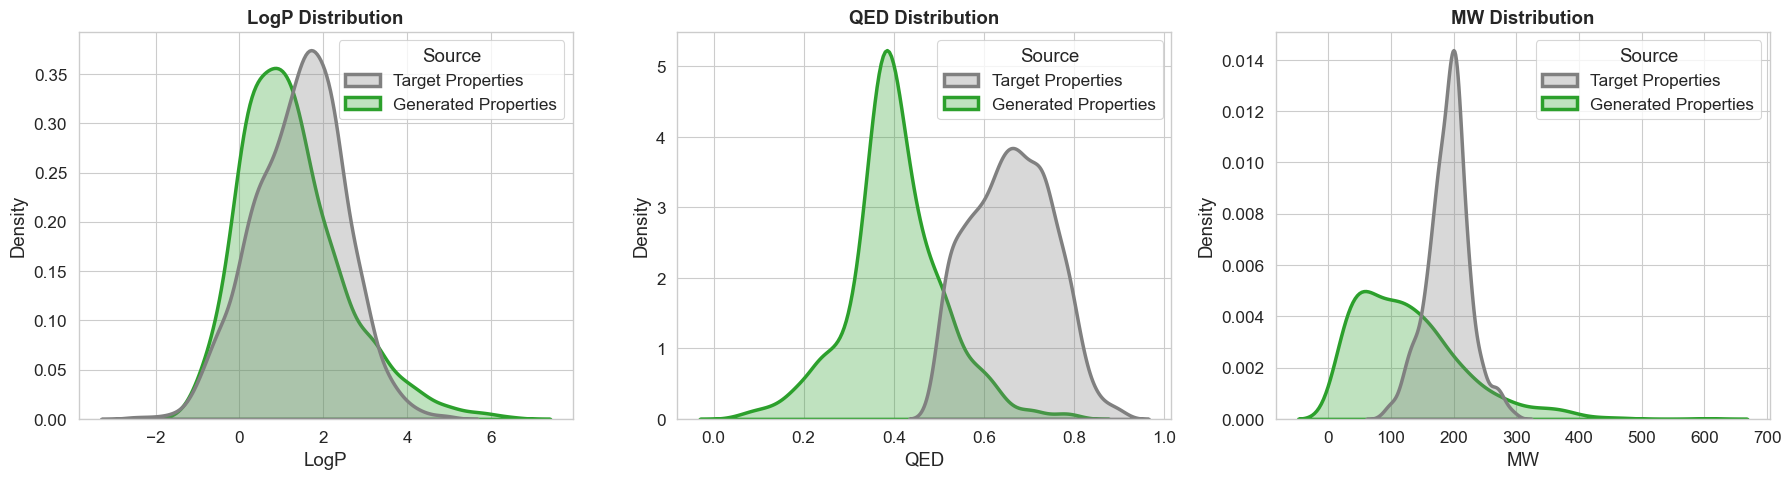

In [26]:
# Get Target Properties and DE-NORMALIZE them
gen_props_df, valid_indices = calculate_generated_properties(results_df)
test_props_df = results_df.loc[valid_indices, ['Target_LogP', 'Target_QED', 'Target_MW']].copy()

# Apply de-normalization (using the min/max values from your load_molecules.ipynb)
# You need to make sure min_logp, max_logp, etc. are available here!
test_props_df['Target_LogP'] = test_props_df['Target_LogP'].apply(lambda x: denormalize(x, min_logp, max_logp))
test_props_df['Target_QED'] = test_props_df['Target_QED'].apply(lambda x: denormalize(x, min_qed, max_qed))
test_props_df['Target_MW'] = test_props_df['Target_MW'].apply(lambda x: denormalize(x, min_mw, max_mw))

test_props_df.columns = ['LogP', 'QED', 'MW']
test_props_df['Source'] = 'Target Properties'

combined_df = pd.concat([test_props_df, gen_props_df], axis=0) 

plot_property_distributions(combined_df)

------------------------------------------------------------------

## Stochastic Generation with Tempering

To generate novel molecules, we run the trained model autoregressively.
* **Tempering:** We apply a temperature factor $T$ to the logits ($p_i = \frac{\exp(z_i/T)}{\sum \exp(z_j/T)}$) to control the diversity of the output.
* **Masking:** We explicitly mask invalid start/pad tokens to ensure the generator produces syntactically valid sequences.

Generating 50 candidates using SWQ Model...
Target: LogP=2.5, QED=0.8, MW=350.0

--------------------------------------------------------------------------------
SWQ RESULTS FOR TARGET: [2.5, 0.8, 350.0]
--------------------------------------------------------------------------------

RANK 1 (Error: 1.6534)
  SMILES: NCCC1=CC=CC=C1OC=P=CCCBr
  PROPERTIES: LogP=2.59 | QED=0.65 | MW=301

RANK 2 (Error: 4.0464)
  SMILES: CCC1NCCCNC2CCCC1(C)[PH1]N2[H]
  PROPERTIES: LogP=1.80 | QED=0.61 | MW=243

RANK 3 (Error: 6.9572)
  SMILES: NC=CC=CC(I)OCl
  PROPERTIES: LogP=1.95 | QED=0.48 | MW=259

Generating SVG visualization...
Saved to: ../generation/swq_top_candidates_1769083911.svg


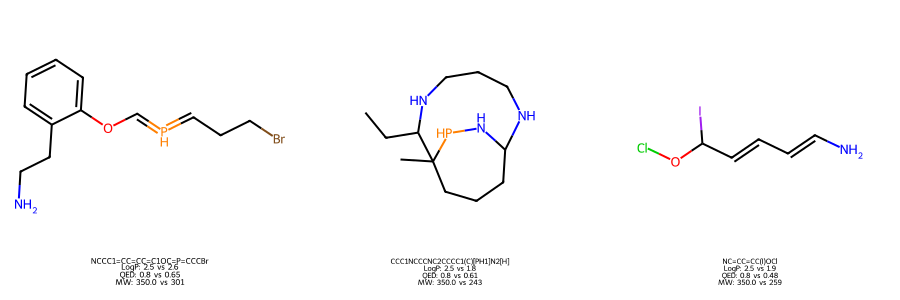

In [30]:
def get_actual_properties(mol):
    """Calculates LogP, QED, MW for an RDKit molecule."""
    if mol is None: return None
    return np.array([
        Descriptors.MolLogP(mol),
        QED.qed(mol),
        Descriptors.ExactMolWt(mol)
    ])

# --- 2. SWQ Generation & Ranking Function ---
def generate_and_rank_swq(target_vals, params, metadata, num_candidates=10, temperature=0.7):
    """
    Generates molecules using the SWQ model, calculates ACTUAL properties,
    and ranks them by how close they are to the target.
    """
    # Unpack metadata for cleaner access
    min_logp, max_logp = metadata['min_logP'], metadata['max_logP']
    min_qed,  max_qed  = metadata['min_qed'],  metadata['max_qed']
    min_mw,   max_mw   = metadata['min_mw'],   metadata['max_mw']

    # 1. Normalize Targets (Raw -> [0, pi])
    # The SWQ model expects these normalized inputs
    target_norm = jnp.array([
        normalize(target_vals[0], min_logp, max_logp),
        normalize(target_vals[1], min_qed,  max_qed),
        normalize(target_vals[2], min_mw,   max_mw)
    ], dtype=jnp.float32)
    
    candidates = []
    
    print(f"Generating {num_candidates} candidates using SWQ Model...")
    print(f"Target: LogP={target_vals[0]}, QED={target_vals[1]}, MW={target_vals[2]}")

    # 2. Key Handling
    # Create a batch of keys for reproducibility within this function
    master_key = jax.random.PRNGKey(int(time.time()*1000))
    keys = jax.random.split(master_key, num_candidates)

    # 3. Generation Loop
    for i in range(num_candidates):
        rng_i = keys[i]
        
        # --- A. SWQ Generation Call ---
        # Using your specific function signature
        generated_bits = molecule_stochastic_generation(
            rng_i, 
            target_norm, # Pass the normalized properties array
            params, 
            temperature=temperature
        )
        
        # --- B. Decode Bits -> SMILES ---
        # Using your specific helper
        gen_selfies, gen_smiles = bits_to_selfies_smiles(generated_bits)
        
        # --- C. Validate & Evaluate ---
        mol = Chem.MolFromSmiles(gen_smiles) if gen_smiles else None
        
        if mol:
            # Calculate ACTUAL properties of the generated structure
            act_props = get_actual_properties(mol) # [LogP, QED, MW]
            
            # Normalize Actuals to compare fairly
            act_norm = np.array([
                normalize(act_props[0], min_logp, max_logp),
                normalize(act_props[1], min_qed,  max_qed),
                normalize(act_props[2], min_mw,   max_mw)
            ])
            
            # Error = Squared Distance in Normalized Space
            error = np.sum((target_norm - act_norm)**2)
            
            candidates.append({
                'SMILES': gen_smiles,
                'SELFIES': gen_selfies,
                'LogP': act_props[0], 'QED': act_props[1], 'MW': act_props[2],
                'Error': error,
                'Mol': mol
            })

    # 4. Rank by Lowest Error
    return sorted(candidates, key=lambda x: x['Error'])

# --- 3. Run & Visualize ---

# A. Setup Metadata (Pack your globals if not already packed)
# Assuming you have min_logp, max_logp etc. defined in your notebook
metadata_swq = {
    'min_logP': min_logp, 'max_logP': max_logp,
    'min_qed':  min_qed,  'max_qed':  max_qed,
    'min_mw':   min_mw,   'max_mw':   max_mw
}

# B. Define Targets
target_values = [2.5, 0.8, 350.0] # [LogP, QED, MW]

# C. Generate
top_swq = generate_and_rank_swq(
    target_values, 
    combined_params, # Trained SWQ params
    metadata_swq, 
    num_candidates=50, # Generate 50 to find good ones
    temperature=0.7
)

# D. Print & Draw Top 3
top_3_swq = top_swq[:3]

print(f"\n{'-'*80}")
print(f"SWQ RESULTS FOR TARGET: {target_values}")
print(f"{'-'*80}")

if not top_3_swq:
    print("No valid molecules found.")
else:
    legends = []
    for i, cand in enumerate(top_3_swq):
        print(f"\nRANK {i+1} (Error: {cand['Error']:.4f})")
        print(f"  SMILES: {cand['SMILES']}")
        print(f"  PROPERTIES: LogP={cand['LogP']:.2f} | QED={cand['QED']:.2f} | MW={cand['MW']:.0f}")
        
        # Create Label for Image
        lbl = (f"{cand['SMILES']}\n" 
               f"LogP: {target_values[0]} vs {cand['LogP']:.1f}\n"
               f"QED: {target_values[1]} vs {cand['QED']:.2f}\n"
               f"MW: {target_values[2]} vs {cand['MW']:.0f}")
        legends.append(lbl)

    # Generate Grid
    print(f"\nGenerating SVG visualization...")
    grid_res = Draw.MolsToGridImage(
        [c['Mol'] for c in top_3_swq],
        molsPerRow=3,
        subImgSize=(300, 300),
        legends=legends,
        useSVG=True
    )
    
    # Handle SVG string extraction safely
    svg_str = grid_res.data if hasattr(grid_res, 'data') else grid_res

    # Save
    fname = f"../generation/swq_top_candidates_{int(time.time())}.svg"
    with open(fname, "w") as f:
        f.write(svg_str)
    print(f"Saved to: {fname}")
    
    # Display
    display(SVG(svg_str))